In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score,roc_auc_score
from sklearn.svm import SVC
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold

In [2]:
path = "/Users/saurabhraj/Desktop/CITY AI/Intro to AI/CW/Data"
df = pd.read_csv(path + "/data.csv")

In [3]:

def plot_consufion_matrix(cm, classes, title = 'Confusion Matrix', normalize = False,cmap = plt.cm.Blues ):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm,interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            plt.text(j,i,cm[i][j], color = 'red', size = 'xx-large', ha = 'center',weight='extra bold')
    
    
def print_evaluation_report(y_test, y_pred, y_pred_proba):
    """This function prints the merices involved for evalutions of the model.
        It also calls the confusioj matrix plot function
    """
    
    cm = confusion_matrix(y_test, y_pred)
    #np.set_printoptions(precision=2)
    #print(cm)
    f1 = f1_score(y_test, y_pred, average='macro')
    auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    
    print('F1 Score : %.2f' % f1)
    print('AUC ROC : %.2f' % auc)
    print('Precision : %.2f' % precision)
    
    classes = [0,1]
    plt.figure()
    plot_consufion_matrix(cm, classes,title = 'Confusion Matrix', normalize = False)
    plt.show()
    return
    
    
    

# 2.2 Under Sampling (without PCA)

In [4]:
def undersample(df):
    count_minority = len(df[df['Bankrupt?'] == 1])
    df_minority = df[df['Bankrupt?'] == 1]
    df_majority = df[df['Bankrupt?'] == 0]
    df_majority_underSampled = df_majority.sample(n=count_minority)
    df_sampled = pd.concat([df_minority, df_majority_underSampled])
    
    return df_sampled

df_sampled = undersample(df)

print(f'DF under sampled shape : {df_sampled.shape}')

def getTrainTest(df):
    X = np.array(df.drop('Bankrupt?', axis=1))
    y = np.array(df['Bankrupt?'])
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state=42,shuffle=True)
    print(f'X train shape : {X_train.shape}')
    print(f'X test shape : {X_test.shape}')
    return (X_train, y_train), (X_test, y_test)

def getTrainTestValidation(df):

    X = df.drop('Bankrupt?', axis=1)
    y = df['Bankrupt?']
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state=42,shuffle=True)
    X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.20, random_state=42,shuffle=True)

    print(f'X train shape : {X_train.shape}')
    print(f'X val shape : {X_val.shape}')
    print(f'X test shape : {X_test.shape}')
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

#(X_train, y_train), (X_val, y_val), (X_test, y_test) = getTrainTestValidation(df_sampled)
(X_train, y_train), (X_test, y_test) = getTrainTest(df_sampled)

DF under sampled shape : (440, 96)
X train shape : (374, 95)
X test shape : (66, 95)


## Decision Tree

F1 Score : 0.82
AUC ROC : 0.84
Precision : 0.85


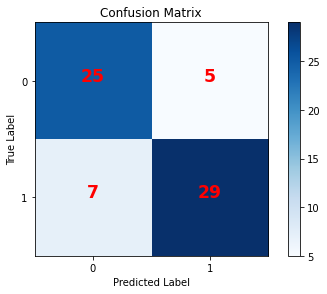

In [27]:
dt = DecisionTreeClassifier(max_depth=40, criterion='entropy', min_samples_split=10).fit(X_train,y_train)
y_pred = dt.predict(X_test)
y_pred_proba = dt.predict_proba(X_test)[:,1]
print_evaluation_report(y_test, y_pred, y_pred_proba)

## Support Vector Classifier

F1 Score : 0.73
AUC ROC : 0.77
Precision : 0.78


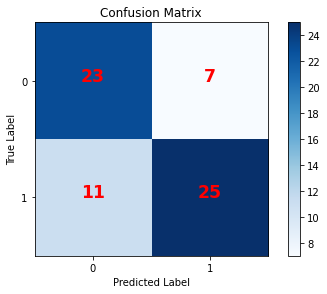

In [28]:
svc = SVC(C=100, kernel = 'rbf', probability=True).fit(X_train, y_train)
y_pred = svc.predict(X_test)
y_pred_proba = svc.predict_proba(X_test)[:,1]
print_evaluation_report(y_test, y_pred, y_pred_proba)

## KNN Classifier

F1 Score : 0.62
AUC ROC : 0.68
Precision : 0.66


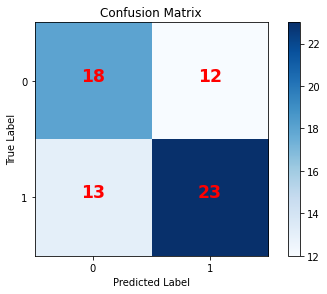

In [29]:
knn = KNeighborsClassifier(n_neighbors=10,weights='distance').fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_pred_proba = knn.predict_proba(X_test)[:,1]
print_evaluation_report(y_test, y_pred, y_pred_proba)


## Random Forest

F1 Score : 0.85
AUC ROC : 0.96
Precision : 0.88


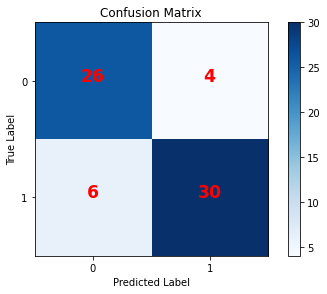

In [30]:
rf = RandomForestClassifier(n_estimators=200, criterion='log_loss').fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:,1]
print_evaluation_report(y_test, y_pred, y_pred_proba)

# Perceptron

Now I will try to train few neural networks and observe if I can improve the performance.


In [6]:
import tensorflow as tf

In [31]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(max_iter=40,tol=0.001,eta0=1)
ppn.fit(X_train, y_train)

y_pred = ppn.predict(X_test)
score = ppn.score(X_test,y_test)
print(score)
#print_evaluation_report(y_test, y_pred, y_pred_proba)

0.5909090909090909


# Next:
* As we can see, Decision trees and Random are performing really well on the datasets.
* Random forest achieved ROC AUC of 0.97.
* So i will explore, random forest a little more in depth.

# K-fold Cross Validation with Random Forest

In [41]:
kf = KFold(5, shuffle=True)
fold = 1
for train_idx, val_idx in kf.split(X_train, y_train):
    rf = RandomForestClassifier(n_estimators=200, criterion='log_loss').fit(X_train[train_idx], y_train[train_idx])
    X_val = X_train[val_idx]
    y_val = y_train[val_idx]
    y_pred = rf.predict(X_val)
    y_pred_proba = rf.predict_proba(X_val)[:,1]
    f1 = f1_score(y_val, y_pred, average='macro')
    auc = roc_auc_score(y_val, y_pred_proba)
    precision = precision_score(y_val, y_pred)
    print('='*50)
    print(f"Fold : {fold}")
    print('='*50)
    print('F1 Score : %.2f' % f1)
    print('AUC ROC : %.2f' % auc)
    print('Precision : %.2f' % precision)
    fold +=1
    
    

Fold : 1
F1 Score : 0.85
AUC ROC : 0.92
Precision : 0.81
Fold : 2
F1 Score : 0.85
AUC ROC : 0.94
Precision : 0.85
Fold : 3
F1 Score : 0.92
AUC ROC : 0.99
Precision : 0.97
Fold : 4
F1 Score : 0.87
AUC ROC : 0.93
Precision : 0.89
Fold : 5
F1 Score : 0.80
AUC ROC : 0.90
Precision : 0.76


In [45]:
# save the model to disk
import pickle
filename = '/Users/saurabhraj/Desktop/CITY AI/Intro to AI/CW/Saved Models/finalized_RFmodel.sav'
pickle.dump(rf, open(filename, 'wb'))

# Neural Networks (MLP)

In [23]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = getTrainTestValidation(df_sampled)

X train shape : (299, 95)
X val shape : (75, 95)
X test shape : (66, 95)


In [46]:
#creating a callback function for our model which finds AUC, Recall and f1_score:


class Evaluation(tf.keras.callbacks.Callback):
    def __init__(self, train_data, val_data):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        
    def on_train_begin(self, logs={}):
        """Initializes list of scores for all epochs"""
        self.auc_val = []
        self.auc_train = []
        self.prec_val = []
        self.prec_train = []
        self.f1_val = []
        self.f1_train = []
        
    def on_epoch_end(self,epoch, logs):
        """Appends the score at the end of each epoch in the initilized emplty list of scores."""
        val_score = np.array(self.model.predict(self.val_data[0]))
        train_score = np.array(self.model.predict(self.train_data[0]))
        val_pred = np.round(val_score)
        train_pred = np.round(train_score)
        val_target = self.val_data[1]
        train_target = self.train_data[1]
        #print(val_target.shape, val_score.shape)
        self.auc_val.append(roc_auc_score(val_target, val_score))
        self.auc_train.append(roc_auc_score(train_target, train_score))
        
        self.prec_val.append(precision_score(val_target, val_pred))
        self.prec_train.append(precision_score(train_target, train_pred))
        
        self.f1_val.append(f1_score(val_target, val_pred, average='macro'))
        self.f1_train.append(f1_score(train_target, train_pred, average='macro'))
        
        return
        
        
        
    

In [29]:
from tensorflow.keras.layers import Dense,Input,Activation,Dropout,Flatten,Embedding, LSTM, Concatenate, Conv1D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
import random as rn
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [30]:
X_train.shape

(299, 95, 1)

In [31]:

model = Sequential()
model.add(Input(shape=(95,)))
model.add(Dense(1000,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

tf.keras.utils.plot_model(model)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1000)              96000     
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               512512    
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 16)                1040      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 642,401
Trainable params: 642,401
Non-tr

In [32]:

es_callback = EarlyStopping(monitor='loss', patience = 5, min_delta=0.0001)
metric_callback = Evaluation((X_train,y_train), (X_val,y_val))
my_callbacks = [es_callback, metric_callback]

model.compile(loss='binary_crossentropy', optimizer='adam')

model.fit(X_train,y_train, epochs=500,validation_data=(X_val, y_val), callbacks=my_callbacks )


Epoch 1/500
10/10 [==============================] - 0s 19ms/step - loss: 111870368.0000 - val_loss: 57201436.0000
Epoch 2/500
10/10 [==============================] - 0s 11ms/step - loss: 26087422.0000 - val_loss: 22193518.0000
Epoch 3/500
10/10 [==============================] - 0s 11ms/step - loss: 23742932.0000 - val_loss: 52919236.0000
Epoch 4/500
10/10 [==============================] - 0s 11ms/step - loss: 35393096.0000 - val_loss: 71528288.0000
Epoch 5/500
10/10 [==============================] - 0s 11ms/step - loss: 33961164.0000 - val_loss: 40645236.0000
Epoch 6/500
10/10 [==============================] - 0s 11ms/step - loss: 23074360.0000 - val_loss: 23872772.0000
Epoch 7/500
10/10 [==============================] - 0s 11ms/step - loss: 16912676.0000 - val_loss: 20989520.0000
Epoch 8/500
10/10 [==============================] - 0s 11ms/step - loss: 11065776.0000 - val_loss: 20062538.0000
Epoch 9/500
10/10 [==============================] - 0s 12ms/step - loss: 8810826.0000 

In [50]:
def print_evaluation_report_NN(model):
    """Print the evaluation report of neural networks:"""
    y_pred_proba = np.asarray(model.predict(X_test))
    y_pred = np.round(np.asarray(model.predict(X_test)))
    print_evaluation_report(y_test, y_pred, y_pred_proba)
    


    auc_train = my_callbacks[1].auc_train
    auc_val = my_callbacks[1].auc_val
    
    n = len(auc_train)

    plt.plot(list(range(n)), auc_train)
    plt.plot(list(range(n)), auc_val)
    plt.title('model AUC')
    plt.legend(['train', 'val'], loc='upper left')
    plt.ylabel('AUC')
    plt.xlabel('epoch')
    plt.show()


    f1_train = my_callbacks[1].f1_train
    f1_val = my_callbacks[1].f1_val

    plt.plot(list(range(n)), f1_train)
    plt.plot(list(range(n)), f1_val)
    plt.title('model F1')
    plt.legend(['train', 'val'], loc='upper left')
    plt.ylabel('f1_score')
    plt.xlabel('epoch')
    plt.show()


    prec_train = my_callbacks[1].prec_train
    prec_val = my_callbacks[1].prec_val

    plt.plot(list(range(n)), f1_train)
    plt.plot(list(range(n)), f1_val)
    plt.title('model Precision')
    plt.legend(['train', 'val'], loc='upper left')
    plt.ylabel('precision_score')
    plt.xlabel('epoch')
    plt.show()


3/3 [==============================] - 0s 1ms/step
F1 Score : 0.67
AUC ROC : 0.67
Precision : 0.73


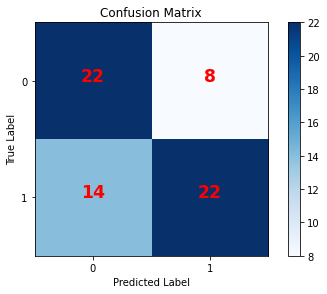

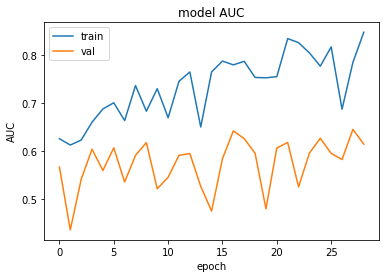

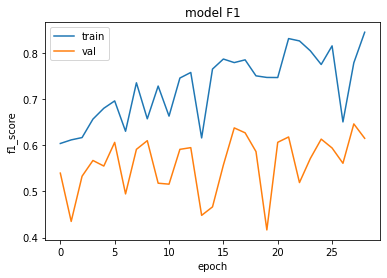

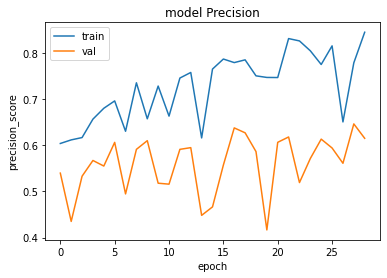

In [14]:
print_evaluation_report_NN()

* As I increased the number of hidden neurons, the model tend to overfit.
* As I increased the dropout rates, the validation score started deviating a lot with train scores.

In [15]:

model = Sequential()
model.add(Input(shape=(95,)))
model.add(Dense(1000,activation='relu',kernel_regularizer='l2'))
#model.add(Dropout(0.1))
model.add(Dense(512, activation='relu',kernel_regularizer='l2'))
#model.add(Dropout(0.1))
model.add(Dense(64, activation='relu',kernel_regularizer='l2'))
model.add(Dense(16, activation='relu',kernel_regularizer='l2'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

tf.keras.utils.plot_model(model)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 1000)              96000     
                                                                 
 dense_11 (Dense)            (None, 512)               512512    
                                                                 
 dense_12 (Dense)            (None, 64)                32832     
                                                                 
 dense_13 (Dense)            (None, 16)                1040      
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 642,401
Trainable params: 642,401
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and

In [16]:

es_callback = EarlyStopping(monitor='loss', patience = 5, min_delta=0.0001)
metric_callback = Evaluation((X_train,y_train), (X_val,y_val))
my_callbacks = [es_callback, metric_callback]

model.compile(loss='binary_crossentropy', optimizer='adam')

model.fit(X_train,y_train, epochs=500,validation_data=(X_val, y_val), callbacks=my_callbacks )



Epoch 1/500
10/10 [==============================] - 0s 21ms/step - loss: 124291928.0000 - val_loss: 15907459.0000
Epoch 2/500
10/10 [==============================] - 0s 13ms/step - loss: 23372944.0000 - val_loss: 27217728.0000
Epoch 3/500
10/10 [==============================] - 0s 12ms/step - loss: 15166584.0000 - val_loss: 25809670.0000
Epoch 4/500
10/10 [==============================] - 0s 12ms/step - loss: 14471743.0000 - val_loss: 28742336.0000
Epoch 5/500
10/10 [==============================] - 0s 12ms/step - loss: 13142721.0000 - val_loss: 21223892.0000
Epoch 6/500
10/10 [==============================] - 0s 12ms/step - loss: 8815794.0000 - val_loss: 20955670.0000
Epoch 7/500
10/10 [==============================] - 0s 13ms/step - loss: 8065559.0000 - val_loss: 10358929.0000
Epoch 8/500
10/10 [==============================] - 0s 12ms/step - loss: 8416275.0000 - val_loss: 13465715.0000
Epoch 9/500
10/10 [==============================] - 0s 12ms/step - loss: 6235826.5000 - v

3/3 [==============================] - 0s 1ms/step
F1 Score : 0.62
AUC ROC : 0.64
Precision : 0.74


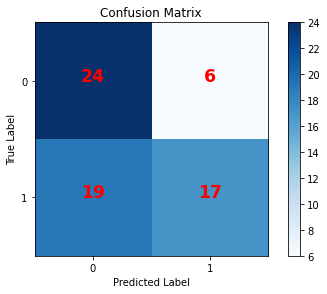

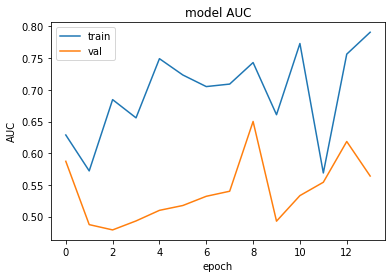

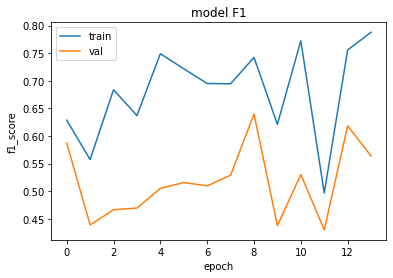

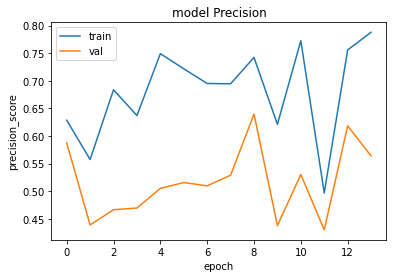

In [19]:
print_evaluation_report_NN(model)

In [129]:
## Apply SMOTE and see the performace

In [54]:
df.shape

(6819, 96)

In [60]:
from imblearn.over_sampling import SMOTE

(X_train, y_train), (X_val, y_val), (X_test, y_test) = getTrainTestValidation(df)

print("Before Oversampling : ")
print(f"                       Bankrupt 1 = {sum(y_train==1)}")
print(f"                       Bankrupt 0 = {sum(y_train==0)}")
print("========="*6)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("After Oversampling : ")
print(f"                       Bankrupt 1 = {sum(y_train_smote==1)}")
print(f"                       Bankrupt 0 = {sum(y_train_smote==0)}")

X train shape : (4636, 95)
X val shape : (1160, 95)
X test shape : (1023, 95)
Before Oversampling : 
                       Bankrupt 1 = 137
                       Bankrupt 0 = 4499
After Oversampling : 
                       Bankrupt 1 = 4499
                       Bankrupt 0 = 4499


In [61]:
model = Sequential()
model.add(Input(shape=(95,)))
model.add(Dense(1000,activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 1000)              96000     
                                                                 
 dense_21 (Dense)            (None, 512)               512512    
                                                                 
 dense_22 (Dense)            (None, 64)                32832     
                                                                 
 dense_23 (Dense)            (None, 16)                1040      
                                                                 
 dense_24 (Dense)            (None, 1)                 17        
                                                                 
Total params: 642,401
Trainable params: 642,401
Non-trainable params: 0
_________________________________________________________________


In [62]:

es_callback = EarlyStopping(monitor='loss', patience = 5, min_delta=0.0001)
metric_callback = Evaluation((X_train,y_train), (X_val,y_val))
my_callbacks = [es_callback, metric_callback]

model.compile(loss='binary_crossentropy', optimizer='adam')

model.fit(X_train,y_train, epochs=500,validation_data=(X_val, y_val), callbacks=my_callbacks )



Epoch 1/500
145/145 [==============================] - 1s 6ms/step - loss: 4484054.5000 - val_loss: 3921183.7500
Epoch 2/500
145/145 [==============================] - 1s 5ms/step - loss: 1493324.7500 - val_loss: 1152816.2500
Epoch 3/500
 56/145 [==========>...................] - ETA: 0s - loss: 665682.1875

/Users/saurabhraj/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


145/145 [==============================] - 1s 5ms/step - loss: 712683.7500 - val_loss: 633581.3750
Epoch 4/500
145/145 [==============================] - 1s 5ms/step - loss: 469920.3438 - val_loss: 203436.4062
Epoch 5/500
145/145 [==============================] - 1s 5ms/step - loss: 213687.4375 - val_loss: 840672.6875
Epoch 6/500
 57/145 [==========>...................] - ETA: 0s - loss: 209987.9688

/Users/saurabhraj/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


145/145 [==============================] - 1s 5ms/step - loss: 158841.9062 - val_loss: 318870.5000
Epoch 7/500
 56/145 [==========>...................] - ETA: 0s - loss: 154921.8594

/Users/saurabhraj/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


145/145 [==============================] - 1s 5ms/step - loss: 110324.0859 - val_loss: 82181.4297
Epoch 8/500
145/145 [==============================] - 1s 5ms/step - loss: 60204.3750 - val_loss: 173791.7969
Epoch 9/500
 57/145 [==========>...................] - ETA: 0s - loss: 264839.4062

/Users/saurabhraj/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


145/145 [==============================] - 1s 5ms/step - loss: 150679.4062 - val_loss: 93916.6875
Epoch 10/500
145/145 [==============================] - 1s 5ms/step - loss: 59218.1055 - val_loss: 83984.9766
Epoch 11/500
145/145 [==============================] - 1s 5ms/step - loss: 33212.6562 - val_loss: 128874.8828
Epoch 12/500
 56/145 [==========>...................] - ETA: 0s - loss: 26617.7773

/Users/saurabhraj/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


145/145 [==============================] - 1s 5ms/step - loss: 22795.7598 - val_loss: 46053.0000
Epoch 13/500
145/145 [==============================] - 1s 5ms/step - loss: 14787.0127 - val_loss: 69893.3828
Epoch 14/500
145/145 [==============================] - 1s 5ms/step - loss: 36515.1875 - val_loss: 119853.7969
Epoch 15/500
145/145 [==============================] - 1s 5ms/step - loss: 69235.2969 - val_loss: 79078.5469
Epoch 16/500
145/145 [==============================] - 1s 5ms/step - loss: 31617.1914 - val_loss: 61317.5742
Epoch 17/500
145/145 [==============================] - 1s 5ms/step - loss: 63673.7266 - val_loss: 86627.8047
Epoch 18/500
 51/145 [=========>....................] - ETA: 0s - loss: 30651.9004

/Users/saurabhraj/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


145/145 [==============================] - 1s 5ms/step - loss: 34092.8242 - val_loss: 43783.8398


32/32 [==============================] - 0s 1ms/step
F1 Score : 0.46
AUC ROC : 0.52
Precision : 0.05


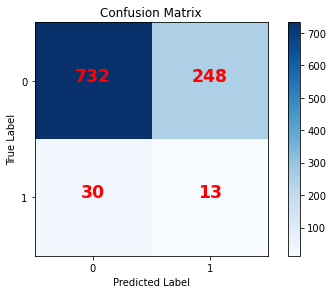

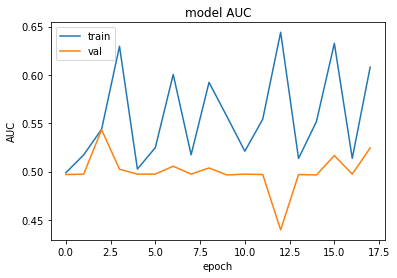

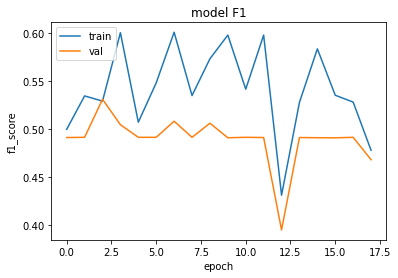

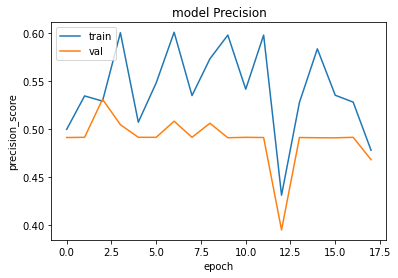

In [63]:
print_evaluation_report_NN(model)

## The same network is performing poorly with SMOTE. Hence, we can conlude that SMOTE is not helping here.

# CNN Network

In [142]:
from tensorflow.keras.layers import Conv1D,Activation,MaxPool1D,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

In [147]:
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)
print(np.unique(y_val))

input_shape = (X_train.shape[0],X_train.shape[1],1)
X_train = X_train.reshape(input_shape)
X_val = X_val.reshape((X_val.shape[0],X_val.shape[1],1))

model = Sequential()
model.add(Conv1D(32,kernel_size=(2),strides=1,padding="valid", input_shape=input_shape[1:]))
model.add(Activation('relu'))
model.add(MaxPool1D(pool_size=2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

es_callback = EarlyStopping(monitor='loss', patience = 5, min_delta=0.00001)
metric_callback = Evaluation((X_train,y_train), (X_val,y_val))
my_callbacks = [es_callback, metric_callback]

model.compile(loss='binary_crossentropy', optimizer = 'adam')
print(model.summary())


[0 1]
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_49 (Conv1D)          (None, 94, 32)            96        
                                                                 
 activation_76 (Activation)  (None, 94, 32)            0         
                                                                 
 max_pooling1d_48 (MaxPoolin  (None, 47, 32)           0         
 g1D)                                                            
                                                                 
 flatten_43 (Flatten)        (None, 1504)              0         
                                                                 
 dense_95 (Dense)            (None, 128)               192640    
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                               

In [148]:
history = model.fit(X_train,y_train,verbose=2,epochs=100,validation_data=(X_val, y_val), callbacks=my_callbacks)

Epoch 1/100
10/10 [==============================] - 0s 845us/step
10/10 - 0s - loss: 66802616.0000 - val_loss: 43424336.0000 - 342ms/epoch - 34ms/step
Epoch 2/100
10/10 [==============================] - 0s 838us/step
10/10 - 0s - loss: 26482960.0000 - val_loss: 15939021.0000 - 82ms/epoch - 8ms/step
Epoch 3/100
10/10 [==============================] - 0s 785us/step
10/10 - 0s - loss: 15923157.0000 - val_loss: 18459118.0000 - 80ms/epoch - 8ms/step
Epoch 4/100
10/10 [==============================] - 0s 774us/step
10/10 - 0s - loss: 10828565.0000 - val_loss: 18121896.0000 - 81ms/epoch - 8ms/step
Epoch 5/100
10/10 [==============================] - 0s 811us/step
10/10 - 0s - loss: 12317383.0000 - val_loss: 12597244.0000 - 81ms/epoch - 8ms/step
Epoch 6/100
10/10 [==============================] - 0s 818us/step
10/10 - 0s - loss: 9416249.0000 - val_loss: 9745123.0000 - 86ms/epoch - 9ms/step
Epoch 7/100
10/10 [==============================] - 0s 806us/step
10/10 - 0s - loss: 9268084.0000 -

3/3 [==============================] - 0s 1ms/step
F1 Score : 0.62
AUC ROC : 0.62
Precision : 0.68


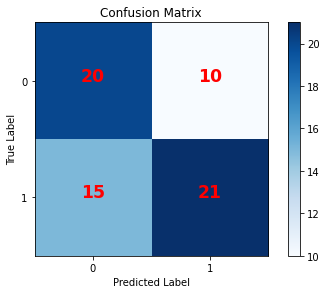

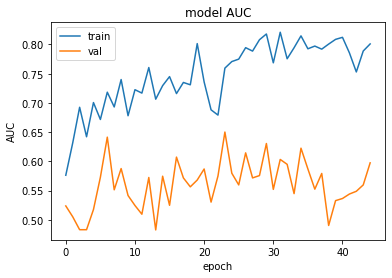

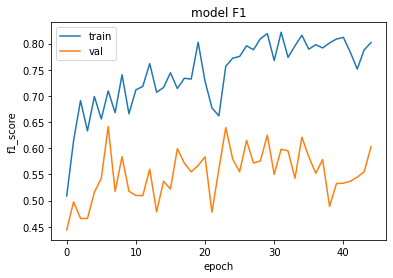

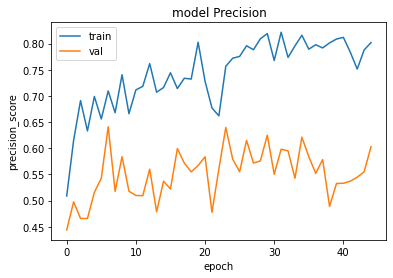

In [149]:
print_evaluation_report_NN(model)

## Observations:
* As filter size of conv1d is reduced, the performance is better compared to large sizes.
* Reducing kernel size from 3 to 2 made it better.
* Adding extra conv1d layer did not help mucH.
* Increasing neurons in Dense layers, caused overfitting.
* Adding L2 regularizations helped a bit.
* Overall not much improvement with CNN.

# Summary

In [153]:

from tabulate import tabulate
print(tabulate([['Decision Trees ( SMOTE + PCA )',0.53,0.61, 0.08],
                ['Support Vector Classifier ( SMOTE + PCA )',0.52,0.68, 0.08],
                ['KNN Classifier (SMOTE + PCA))',0.52,0.73,0.10],
               ['Random Forest Classifier (PCA + SMOTE)', 0.55, 0.76,  0.11],
               ['Gaussian Naive Bayes (PCA + SMOTE)', 0.40,0.62,0.05],
               ['Decision Tree (Undersampled)', 0.82, 0.84,0.85],
               ['Support Vector Classifier (Undersampled)', 0.73, 0.77,0.78],
               ['KNN Classifier (Undersampled)', 0.62,0.68,0.66],
               ['Random Forest (Undersampled)', 0.85,0.96,0.88],
               ['MLP 5 layered (with Dropout)(Undersampled)', 0.67,0.67,0.73],
               ['MLP 5 layered (with L2 Reg)(Undersampled)', 0.62, 0.64,0.74],
               ['MLP 5 layered (without Reg)(SMOTE)', 0.42,0.56,0.05],
               ['CNN (Undersampled)', 0.62,0.62,0.68]],
               
headers=['Model','F1 Score','AUC ROC','Precision'], tablefmt='orgtbl'))

| Model                                      |   F1 Score |   AUC ROC |   Precision |
|--------------------------------------------+------------+-----------+-------------|
| Decision Trees ( SMOTE + PCA )             |       0.53 |      0.61 |        0.08 |
| Support Vector Classifier ( SMOTE + PCA )  |       0.52 |      0.68 |        0.08 |
| KNN Classifier (SMOTE + PCA))              |       0.52 |      0.73 |        0.1  |
| Random Forest Classifier (PCA + SMOTE)     |       0.55 |      0.76 |        0.11 |
| Gaussian Naive Bayes (PCA + SMOTE)         |       0.4  |      0.62 |        0.05 |
| Decision Tree (Undersampled)               |       0.82 |      0.84 |        0.85 |
| Support Vector Classifier (Undersampled)   |       0.73 |      0.77 |        0.78 |
| KNN Classifier (Undersampled)              |       0.62 |      0.68 |        0.66 |
| Random Forest (Undersampled)               |       0.85 |      0.96 |        0.88 |
| MLP 5 layered (with Dropout)(Undersampled) |       0